In [ ]:
!pip install -q transformers accelerate

from transformers import AutoModelForCausalLM, AutoTokenizer
from huggingface_hub import login
import torch
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import time

login()

In [ ]:
# Load target & draft models
target_model_name = "gpt2-medium"
draft_model_name = "distilgpt2"

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.padding_side = 'left'

target_model = AutoModelForCausalLM.from_pretrained(target_model_name)
draft_model = AutoModelForCausalLM.from_pretrained(draft_model_name)

target_model.resize_token_embeddings(len(tokenizer))
draft_model.resize_token_embeddings(len(tokenizer))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(50258, 768)

In [ ]:
# Sample data
prefixes = [
    "To bake a cake, you need to",
    "The human body contains approximately",
    "During photosynthesis, plants convert",
    "The internet was invented in",
    "Einstein's theory of relativity states that",
    "The three primary colors are",
    "Climate change is caused by",
    "Democracy is a form of government where"
]

inputs = tokenizer(prefixes, padding=True, return_tensors="pt")
input_batch = inputs['input_ids']


In [ ]:
class SpeculativeSampler:

    def __init__(self, draft_model, target_model, pad_token_id):
        self.draft_model = draft_model
        self.target_model = target_model
        self.pad_token_id = pad_token_id

    def generate_draft_tokens(self, input_sequences, k):
        """Sample k tokens autoregressivley from the draft model."""
        sequences = input_sequences.clone()
        draft_log_probs = []

        with torch.no_grad():
            for _ in range(k):
                outputs = self.draft_model.generate(
                    sequences,
                    max_new_tokens=1,
                    do_sample=True,
                    top_k=50,
                    return_dict_in_generate=True,
                    output_scores=True,
                    pad_token_id=self.pad_token_id
                )

                # Log probabilities for the new token
                logits = outputs.scores[0]  # [B, V]
                log_probs = F.log_softmax(logits, dim=-1)
                new_tokens = outputs.sequences[:, -1].unsqueeze(-1)
                draft_log_probs.append(log_probs.unsqueeze(1))

                sequences = outputs.sequences

        draft_log_probs = torch.cat(draft_log_probs, dim=1)  # [B, k, V]
        return sequences, draft_log_probs


    def score_draft_tokens(self, seq_draft, k):
        """Get target models scores on the tokens proposed by the draft model"""
        with torch.no_grad():
            outputs = self.target_model(seq_draft)
            logits = outputs.logits  # [B, L, V]
            log_probs = F.log_softmax(logits, dim=-1)

            # Logits for draft sequence and next token
            target_log_probs = log_probs[:, -k-1:, :]

        return target_log_probs


    def accept_tokens(self, draft_log_probs, target_log_probs, seq_draft, k):
        original_sequences = seq_draft[:, :-k]
        B, L = original_sequences.shape
        draft_tokens = seq_draft[:, -k:]

        target_probs = target_log_probs.exp()
        draft_probs = draft_log_probs.exp()
        draft_probs_ext = torch.cat([draft_probs, torch.zeros((B, 1, draft_probs.size(2)), device=draft_probs.device)], dim=1)

        # Accept tokens
        p_accept_target = target_probs[:, :-1, :].gather(dim=2, index=draft_tokens.unsqueeze(-1)).squeeze(-1)
        p_accept_draft  = draft_probs[:, :, :].gather(dim=2, index=draft_tokens.unsqueeze(-1)).squeeze(-1)
        p_accept = (p_accept_target / p_accept_draft).clamp(max=1)
        n_tensor = torch.rand_like(p_accept)
        accepted = (p_accept >= n_tensor).long()
        accepted_mask = torch.cumprod(accepted, dim=1)
        accepted_tokens = (draft_tokens * accepted_mask) + (self.pad_token_id * (1 - accepted_mask))
        new_seq = torch.cat([original_sequences, accepted_tokens], dim=1)
        num_gen = accepted_mask.sum().item()

        # Sample the next token
        zero_positions = (accepted_mask == 0).int().argmax(dim=1, keepdim=True)
        all_accepted = accepted_mask[:, -1].unsqueeze(-1)  # [B, 1]
        next_token_idx = torch.where(all_accepted.bool(), k, zero_positions).view(-1).long()
        batch_idx = torch.arange(B, device=target_log_probs.device)

        # create resample distribution
        resample_logits = (target_probs-draft_probs_ext).clamp(min=0)
        next_tokens = torch.argmax(F.softmax(resample_logits[batch_idx, next_token_idx, :], dim=1), dim=-1, keepdim=True) # [B, 1]
        new_seq = torch.cat([new_seq, torch.full((B, 1), self.pad_token_id, device=new_seq.device)], dim=1)
        new_seq[batch_idx, (next_token_idx+L)] = next_tokens.view(-1)
        num_gen += B

        # Right-pad sequences
        valid_mask = (new_seq != self.pad_token_id)
        valid_counts = valid_mask.sum(dim=1)  # [B]
        padded_seq = torch.full_like(new_seq, self.pad_token_id)
        indices = torch.arange(new_seq.size(1), device=new_seq.device).unsqueeze(0)  # [1, L]
        insertion_mask = indices >= (new_seq.size(1) - valid_counts).unsqueeze(1)  # [B, L]

        # Insert valid tokens at the correct positions
        padded_seq[insertion_mask.bool()] = new_seq[valid_mask]

        return padded_seq, accepted_mask, num_gen


    def speculative_sample_step(self, prefixes, k = 5):
        """Perform one step of speculative decoding."""
        start = time.time()

        # Generate draft tokens
        seq_draft, draft_log_probs = self.generate_draft_tokens(prefixes, k)

        # Score draft tokens with target model
        target_log_probs = self.score_draft_tokens(seq_draft, k)

        # Accept tokens based on score comparison
        new_seq, accepted_mask, n_gen = self.accept_tokens(draft_log_probs, target_log_probs, seq_draft, k)

        end = time.time()

        # Calculate statistics
        acceptance_rate = accepted_mask.float().mean().item()
        tokens_accepted = accepted_mask.sum(dim=1).float().mean().item()

        stats = {
            'acceptance_rate': acceptance_rate,
            'avg_tokens_accepted': tokens_accepted,
            'n_gen': n_gen,
            'time': end-start,
        }

        return new_seq, stats


# Normal AR for comparison
def autoregressive_sampler(target_model, input_sequences, pad_token_id):
    "Regular AR sampler"
    start = time.time()
    with torch.no_grad():
        outputs = target_model.generate(
            input_sequences,
            max_new_tokens=1,
            do_sample=True,
            top_k=50,
            return_dict_in_generate=True,
            output_scores=True,
            pad_token_id=pad_token_id
        )

        # Log probabilities for the new token
        logits = outputs.scores[0]  # [B, V]
        log_probs = F.log_softmax(logits, dim=-1)
        new_tokens = outputs.sequences[:, -1].unsqueeze(-1)
        token_scores = torch.gather(log_probs, dim=1, index=new_tokens)

    end = time.time()
    return outputs, (end-start), input_sequences.size(0)


In [ ]:
k = 5

# Initialise sampler
sampler = SpeculativeSampler(
    draft_model=draft_model,
    target_model=target_model,
    pad_token_id=tokenizer.pad_token_id
)

# Perform speculative sampling
final_sequences, stats = sampler.speculative_sample_step(input_batch, k)

print("Speculative Sampling")
print(f"Acceptance rate: {stats['acceptance_rate']:.2%}")
print(f"Average tokens accepted: {stats['avg_tokens_accepted']:.1f}")
print(f"Num generated (and accepted): {stats['n_gen']}")
print(f"Time taken: {stats['time']:.2f}s")
print(f"Time per token: {stats['time']/stats['n_gen']:.2f}s")
print()

_, time_taken, n_gen = autoregressive_sampler(target_model, input_batch, tokenizer.pad_token_id)

print("Regular AR")
print(f"Average num generated: {n_gen}")
print(f"Time taken: {time_taken:.2f}s")
print(f"Time per token: {time_taken/n_gen:.2f}s")


Speculative Sampling
Acceptance rate: 22.50%
Average tokens accepted: 1.1
Num generated (and accepted): 17
Time taken: 2.02s
Time per token: 0.12s

Regular AR
Average num generated: 8
Time taken: 0.69s
Time per token: 0.09s


In [ ]:
# Average results

def avg_comparison(n, draft_model, target_model, input_batch, k, pad_token_id):
    total_stats = {'sps': {'acceptance_rate': 0, 'avg_tokens_accepted': 0, 'n_gen': 0, 'time': 0}, 'ar': {'n_gen': 0, 'time': 0}}

    # Initialise sampler
    sampler = SpeculativeSampler(
        draft_model=draft_model,
        target_model=target_model,
        pad_token_id=tokenizer.pad_token_id
    )

    for i in range(n):
        _, stats = sampler.speculative_sample_step(input_batch, k)
        total_stats['sps']['acceptance_rate'] += stats['acceptance_rate']
        total_stats['sps']['avg_tokens_accepted'] += stats['avg_tokens_accepted']
        total_stats['sps']['n_gen'] += stats['n_gen']
        total_stats['sps']['time'] += stats['time']

        _, time_taken, n_gen = autoregressive_sampler(target_model, input_batch, k)
        total_stats['ar']['n_gen'] += n_gen
        total_stats['ar']['time'] += time_taken

    for key in total_stats:
        for subkey in total_stats[key]:
            total_stats[key][subkey] /= n

    print("Speculative Sampling")
    print(f"Acceptance rate: {total_stats['sps']['acceptance_rate']:.2%}")
    print(f"Average tokens accepted: {total_stats['sps']['avg_tokens_accepted']:.2f}")
    print(f"Average num generated: {total_stats['sps']['n_gen']}")
    print(f"Average time taken: {total_stats['sps']['time']:.2f}s")
    print(f"Average time per token: {total_stats['sps']['time']/total_stats['sps']['n_gen']:.2f}")
    print()

    print("Autoregressive Sampling")
    print(f"Average num generated: {total_stats['ar']['n_gen']}")
    print(f"Average time taken: {total_stats['ar']['time']:.2f}s")
    print(f"Average time per token: {total_stats['ar']['time']/total_stats['ar']['n_gen']:.2f}")

    return total_stats

In [ ]:
test_ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
k_stats = {}
n = 100
for k in test_ks:
    print(f"k = {k}")
    stats = avg_comparison(5, draft_model, target_model, input_batch, k, tokenizer.pad_token_id)
    k_stats[k] = stats
    print()

k = 1
Speculative Sampling
Acceptance rate: 60.00%
Average tokens accepted: 0.6
Average num generated: 12.8
Average time taken: 0.95s
Average time per token: 0.07

Autoregressive Sampling
Average num generated: 8.0
Average time taken: 0.75s
Average time per token: 0.09

k = 2
Speculative Sampling
Acceptance rate: 32.50%
Average tokens accepted: 0.7
Average num generated: 13.2
Average time taken: 1.20s
Average time per token: 0.09

Autoregressive Sampling
Average num generated: 8.0
Average time taken: 0.71s
Average time per token: 0.09

k = 3
Speculative Sampling
Acceptance rate: 29.17%
Average tokens accepted: 0.9
Average num generated: 15.0
Average time taken: 1.41s
Average time per token: 0.09

Autoregressive Sampling
Average num generated: 8.0
Average time taken: 0.74s
Average time per token: 0.09

k = 4
Speculative Sampling
Acceptance rate: 16.88%
Average tokens accepted: 0.7
Average num generated: 13.4
Average time taken: 1.63s
Average time per token: 0.12

Autoregressive Sampling

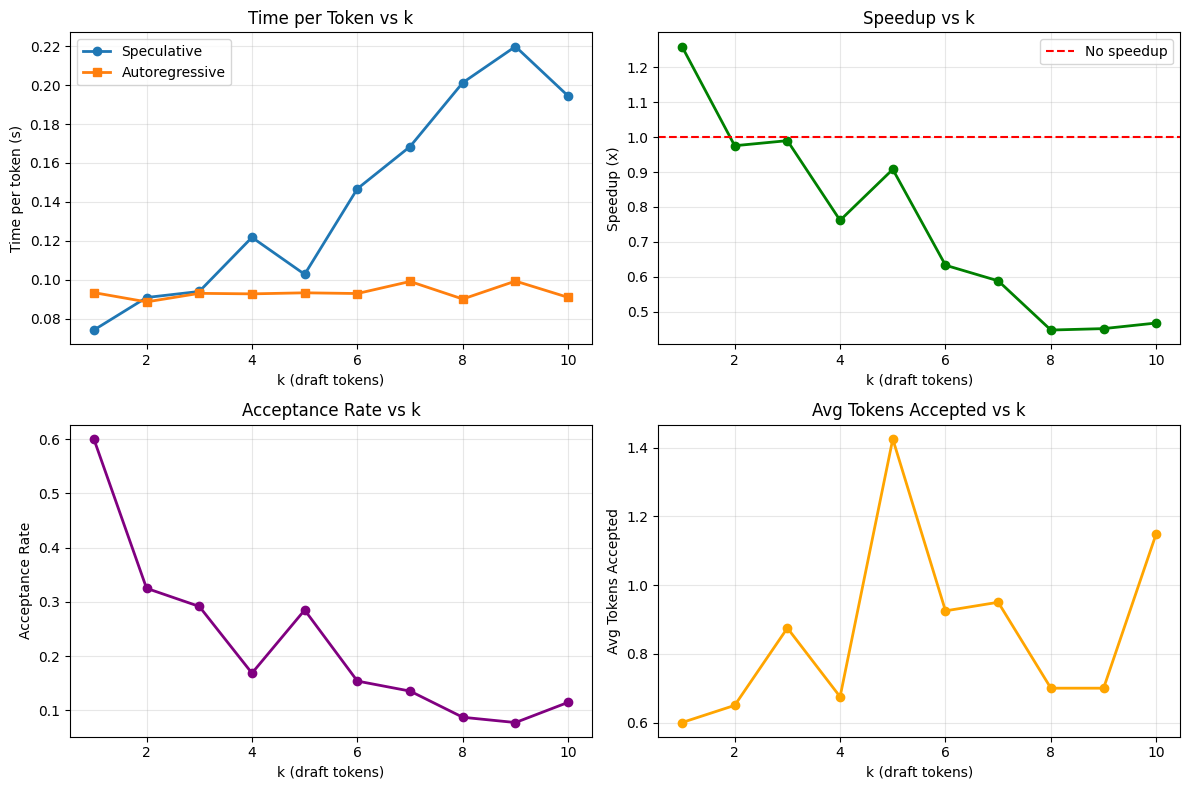

In [ ]:
import matplotlib.pyplot as plt

def plot_k_comparison(k_stats):
    """Simple plots comparing different k values."""

    # Extract data
    ks = list(k_stats.keys())

    # Speculative sampling metrics
    sps_acceptance = [k_stats[k]['sps']['acceptance_rate'] for k in ks]
    sps_avg_accepted = [k_stats[k]['sps']['avg_tokens_accepted'] for k in ks]
    sps_time_per_token = [k_stats[k]['sps']['time'] / k_stats[k]['sps']['n_gen'] for k in ks]

    # Autoregressive metrics
    ar_time_per_token = [k_stats[k]['ar']['time'] / k_stats[k]['ar']['n_gen'] for k in ks]

    # Speedup
    speedup = [ar_time_per_token[i] / sps_time_per_token[i] for i in range(len(ks))]

    # Create 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Plot 1: Time per token comparison
    axes[0, 0].plot(ks, sps_time_per_token, 'o-', label='Speculative', linewidth=2)
    axes[0, 0].plot(ks, ar_time_per_token, 's-', label='Autoregressive', linewidth=2)
    axes[0, 0].set_xlabel('k (draft tokens)')
    axes[0, 0].set_ylabel('Time per token (s)')
    axes[0, 0].set_title('Time per Token vs k')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Speedup
    axes[0, 1].plot(ks, speedup, 'o-', color='green', linewidth=2)
    axes[0, 1].axhline(y=1, color='red', linestyle='--', label='No speedup')
    axes[0, 1].set_xlabel('k (draft tokens)')
    axes[0, 1].set_ylabel('Speedup (x)')
    axes[0, 1].set_title('Speedup vs k')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Acceptance rate
    axes[1, 0].plot(ks, sps_acceptance, 'o-', color='purple', linewidth=2)
    axes[1, 0].set_xlabel('k (draft tokens)')
    axes[1, 0].set_ylabel('Acceptance Rate')
    axes[1, 0].set_title('Acceptance Rate vs k')
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Average tokens accepted
    axes[1, 1].plot(ks, sps_avg_accepted, 'o-', color='orange', linewidth=2)
    axes[1, 1].set_xlabel('k (draft tokens)')
    axes[1, 1].set_ylabel('Avg Tokens Accepted')
    axes[1, 1].set_title('Avg Tokens Accepted vs k')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Usage:
plot_k_comparison(k_stats)